## Test Point Cloud Register


In [3]:
import torch
import numpy as np
import open3d as o3d
from pytorch3d.loss import chamfer_distance
from pytorch3d.transforms import so3_exponential_map
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_point_cloud(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    return torch.tensor(np.asarray(pcd.points), dtype=torch.float32).to(device)

def visualize_step(source, target, transformed, step):
    source_pcd = o3d.geometry.PointCloud()
    source_pcd.points = o3d.utility.Vector3dVector(source.cpu().numpy())
    source_pcd.paint_uniform_color([1, 0, 0])  

    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(target.cpu().numpy())
    target_pcd.paint_uniform_color([0, 1, 0])  

    transformed_pcd = o3d.geometry.PointCloud()
    transformed_pcd.points = o3d.utility.Vector3dVector(transformed.cpu().detach().numpy())
    transformed_pcd.paint_uniform_color([0, 0, 1])  

    print(f"Step {step}: Visualizing...")
    o3d.visualization.draw_geometries([source_pcd, target_pcd, transformed_pcd])

source_pcd = load_point_cloud("render_geometry.ply")  
target_pcd = load_point_cloud("smal_target_cow_alph5.ply")

rot_vector = torch.zeros(3, requires_grad=True, device=device)  
translation = torch.zeros(3, requires_grad=True, device=device) 

optimizer = torch.optim.Adam([rot_vector, translation], lr=0.01)

num_iterations = 20
for i in range(num_iterations):
    optimizer.zero_grad()
    
    
    R = so3_exponential_map(rot_vector.unsqueeze(0)).squeeze(0)  
    
    transformed_pcd = (source_pcd @ R.T) + translation  
    
    loss, _ = chamfer_distance(transformed_pcd.unsqueeze(0), target_pcd.unsqueeze(0))
    
    loss.backward()
    optimizer.step()
    
    print(f"Iteration {i}: Loss = {loss.item():.6f}")

    if i % 2 == 0:
        visualize_step(source_pcd, target_pcd, transformed_pcd, i)

visualize_step(source_pcd, target_pcd, transformed_pcd, "Final")


Step 0: Loss = 0.008158 (Visualizing...)
Step 1: Loss = 0.006711 (Visualizing...)
Step 2: Loss = 0.006242 (Visualizing...)
Step 3: Loss = 0.006111 (Visualizing...)
Step 4: Loss = 0.005868 (Visualizing...)
Step 5: Loss = 0.005571 (Visualizing...)
Step 6: Loss = 0.005374 (Visualizing...)
Step 7: Loss = 0.005338 (Visualizing...)
Step 8: Loss = 0.005405 (Visualizing...)
Step 9: Loss = 0.005474 (Visualizing...)
Step 10: Loss = 0.005496 (Visualizing...)
Step 11: Loss = 0.005491 (Visualizing...)
Step 12: Loss = 0.005485 (Visualizing...)
Step 13: Loss = 0.005489 (Visualizing...)
Step 14: Loss = 0.005487 (Visualizing...)
Step 15: Loss = 0.005465 (Visualizing...)
Step 16: Loss = 0.005415 (Visualizing...)
Step 17: Loss = 0.005351 (Visualizing...)
Step 18: Loss = 0.005289 (Visualizing...)
Step 19: Loss = 0.005241 (Visualizing...)
Step 20: Loss = 0.005215 (Visualizing...)
Step 21: Loss = 0.005214 (Visualizing...)
Step 22: Loss = 0.005225 (Visualizing...)
Step 23: Loss = 0.005234 (Visualizing...)
St

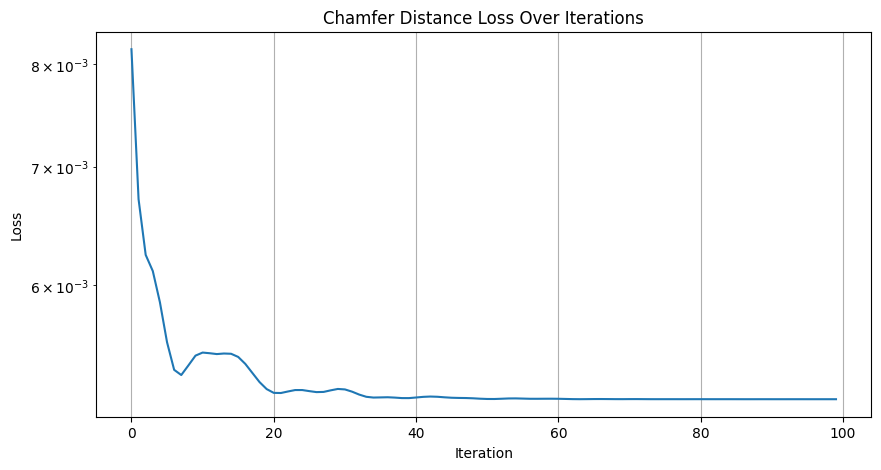

In [ ]:
import torch
import numpy as np
import open3d as o3d
import time
from pytorch3d.loss import chamfer_distance
from pytorch3d.transforms import so3_exponential_map
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_point_cloud(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    return torch.tensor(np.asarray(pcd.points), dtype=torch.float32).to(device)

class RegistrationVisualizer:
    """Class for continuous visualization of point cloud registration"""
    def __init__(self, source, target):
        # Create a window and add geometries
        self.vis = o3d.visualization.Visualizer()
        self.vis.create_window(window_name="Point Cloud Registration")
        
        # Create point clouds
        self.source_pcd = o3d.geometry.PointCloud()
        self.source_pcd.points = o3d.utility.Vector3dVector(source.cpu().numpy())
        self.source_pcd.paint_uniform_color([1, 0, 0])  # Red for source
        
        self.target_pcd = o3d.geometry.PointCloud()
        self.target_pcd.points = o3d.utility.Vector3dVector(target.cpu().numpy())
        self.target_pcd.paint_uniform_color([0, 1, 0])  # Green for target
        
        self.transformed_pcd = o3d.geometry.PointCloud()
        self.transformed_pcd.points = o3d.utility.Vector3dVector(source.cpu().numpy())
        self.transformed_pcd.paint_uniform_color([0, 0, 1])  # Blue for transformed
        
        # Add to visualizer
        self.vis.add_geometry(self.source_pcd)
        self.vis.add_geometry(self.target_pcd)
        self.vis.add_geometry(self.transformed_pcd)
        
        # Set visualization options
        opt = self.vis.get_render_option()
        opt.background_color = np.array([0.1, 0.1, 0.1])
        opt.point_size = 2.0
        opt.point_show_normal = False  # Make sure this is false to get circular points

        # Set initial view
        self.vis.reset_view_point(True)
        self.vis.update_renderer()
        
        # Initialize loss history
        self.loss_history = []
    
    def update(self, transformed_points, iteration, loss):
        """Update visualization with new transformed points"""
        self.loss_history.append(loss)
        
        # Update transformed point cloud
        self.transformed_pcd.points = o3d.utility.Vector3dVector(transformed_points.cpu().detach().numpy())
        self.vis.update_geometry(self.transformed_pcd)
        
        # Print progress instead of updating window title
        print(f"Step {iteration}: Loss = {loss:.6f} (Visualizing...)")
        
         # Make sure point size stays small
        self.vis.get_render_option().point_size = 2.0
        # Update view and render
        self.vis.poll_events()
        self.vis.update_renderer()
        time.sleep(0.05)  # Small delay to make visualization smoother
    
    def plot_loss_history(self):
        """Plot the loss history"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.title('Chamfer Distance Loss Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.yscale('log')  # Log scale often helps visualize convergence
        plt.grid(True)
        plt.show()
    
    def close(self):
        """Close the visualizer"""
        self.vis.destroy_window()

# Load point clouds
source_pcd = load_point_cloud("render_geometry.ply")
target_pcd = load_point_cloud("template_aligned.ply")

# Initialize the visualizer
visualizer = RegistrationVisualizer(source_pcd, target_pcd)

# Setup optimization
rot_vector = torch.zeros(3, requires_grad=True, device=device)  
translation = torch.zeros(3, requires_grad=True, device=device) 
optimizer = torch.optim.Adam([rot_vector, translation], lr=0.01)

# Run the optimization with continuous visualization
num_iterations = 50  # Same as your original code, adjust as needed

try:
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Calculate rotation matrix from axis-angle
        R = so3_exponential_map(rot_vector.unsqueeze(0)).squeeze(0)  
        
        # Apply transformation
        transformed_pcd = (source_pcd @ R.T) + translation  
        
        # Calculate loss
        loss, _ = chamfer_distance(transformed_pcd.unsqueeze(0), target_pcd.unsqueeze(0))
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Update visualization
        visualizer.update(transformed_pcd, i, loss.item())
        
except KeyboardInterrupt:
    print("Optimization interrupted by user")
finally:
    print("\nOptimization completed")
    print(f"Final loss: {loss.item():.6f}")

# Plot loss history
visualizer.plot_loss_history()

# Close the visualizer when done
visualizer.close()